In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8765432098765432, Loss: 0.5846881866455078
Checkpoint 20, Accuracy: 0.8395061728395061, Loss: 0.6262710006148727
Checkpoint 30, Accuracy: 0.845679012345679, Loss: 0.5160495969984267
Checkpoint 40, Accuracy: 0.8148148148148148, Loss: 0.566796479401765
Checkpoint 50, Accuracy: 0.8518518518518519, Loss: 0.5127475879810475
Checkpoint 60, Accuracy: 0.8827160493827161, Loss: 0.4642852853845667
Checkpoint 70, Accuracy: 0.9012345679012346, Loss: 0.4036905853836625
Checkpoint 80, Accuracy: 0.8950617283950617, Loss: 0.37447071075439453
Checkpoint 90, Accuracy: 0.9197530864197531, Loss: 0.3721686469184028
Checkpoint 100, Accuracy: 0.9074074074074074, Loss: 0.33860337292706527
Checkpoint 110, Accuracy: 0.9135802469135802, Loss: 0.3053882740162037
Checkpoint 120, Accuracy: 0.9629629629629629, Loss: 0.2765722627992983
Checkpoint 130, Accuracy: 0.9567901234567902, Loss: 0.2793554023460106
Checkpoint 140, Accuracy: 0.9506172839506173, Loss: 0.25141998573585794
Checkpoint 150

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

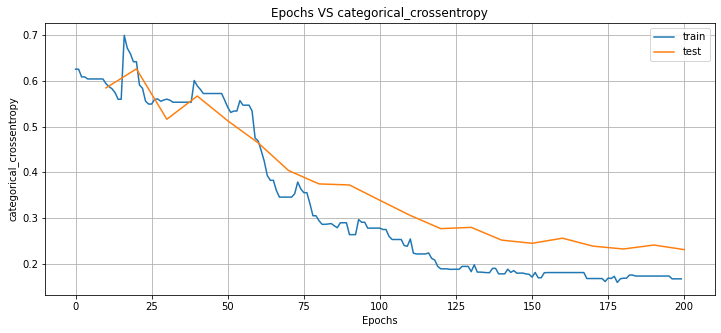

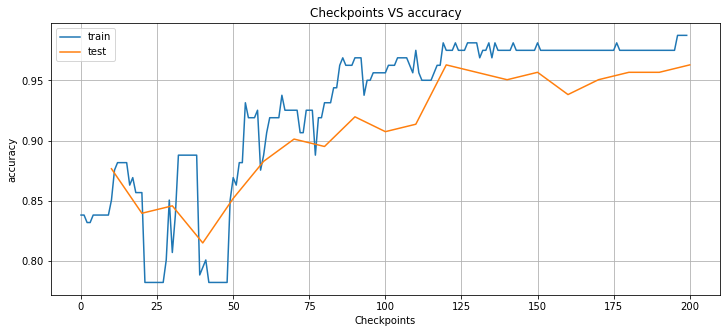

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9155683  0.06723206 0.01719956]
[1. 0. 0.] <-> [0.7269571  0.05354434 0.21949862]
[1. 0. 0.] <-> [0.76344633 0.02970245 0.20685123]
[1. 0. 0.] <-> [0.8606715  0.03811457 0.10121389]
[0. 1. 0.] <-> [8.723050e-02 9.120011e-01 7.684119e-04]
[0. 1. 0.] <-> [0.45377523 0.54163164 0.00459316]
[1. 0. 0.] <-> [0.91751534 0.05818334 0.0243014 ]
[0. 1. 0.] <-> [9.1936462e-02 9.0731412e-01 7.4946485e-04]
[0. 0. 1.] <-> [0.1321292  0.00722283 0.8606479 ]
[0. 0. 1.] <-> [0.56111497 0.01381525 0.42506975]
[0. 1. 0.] <-> [0.49861062 0.49399808 0.00739125]
[1. 0. 0.] <-> [0.89037704 0.01827255 0.09135045]
[0. 0. 1.] <-> [0.3867387  0.01836105 0.5949003 ]
[1. 0. 0.] <-> [0.93142074 0.03037976 0.03819944]
[1. 0. 0.] <-> [0.8289547  0.05496552 0.11607977]
[1. 0. 0.] <-> [0.8739894  0.04734248 0.07866814]
[0. 1. 0.] <-> [8.587854e-02 9.133332e-01 7.882225e-04]
[1. 0. 0.] <-> [0.8372618  0.1119022  0.05083606]
[0. 1. 0.] <-> [0.56956244 0.42440954 0.00602807]
[1. 0. 0.] <-> [0.89101106 0.

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8765432098765432, 'mean_square_error': 0.31340896813949903, 'categorical_crossentropy': 0.5846881866455078, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 19, 'tn_hit': 11, 'fn_hit': 0}, 1: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 6}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 10} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 0.35739754395615325, 'categorical_crossentropy': 0.6262710006148727, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 26, 'tn_hit': 4, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 10}}, 'checkpoint': 20} 


{'accuracy': 0.845679012345679, 'mean_square_error': 0.2902624873065338, 'categorical_crossentropy': 0.5160495969984267, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 25, 'tn_hit': 5, 'fn_hit': 0}, 1: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 15}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 94, 'fn_hi

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.8782017  -1.126328   -1.0795482   0.00812434  0.159762  ]
 bias: 0.3650374412536621

Neuron 1: weights:
[ 0.01118211  1.5154357  -0.03943365 -1.0937028  -1.311823  ]
 bias: 1.0832040309906006

Neuron 2: weights:
[-0.01976796  0.15463096 -0.34099483 -0.08479716 -0.2923008 ]
 bias: 0.19200050830841064

Neuron 3: weights:
[-0.6923215   1.1664181   1.5645419  -0.00840527 -0.03409138]
 bias: -0.6252923011779785

$
Layer 2
Neuron 0: weights:
[ 0.6576633   2.5416136   0.73428977 -0.99562377]
 bias: -0.08243522047996521

Neuron 1: weights:
[-3.          1.2267979   0.15766782  2.770017  ]
 bias: 0.0628129169344902

Neuron 2: weights:
[ 2.6690915  -3.         -0.0100425  -0.00797657]
 bias: 0.052185848355293274

$

